##### Imports 

In [1]:
import pandas as pd
import numpy as np
import csv
import logging
import os
from functions.temp_funcs import read_file, merge_dataframes, drop_cols, drop_nans, filter_date_range, \
filter_df, create_container_col, create_cond_df

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context = "notebook", style = "white", font="verdana") # font_scale = 1.35)

##### Logging Set-up

In [2]:
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

##### Pandas Display Settings

In [3]:
pd.set_option("display.max_colwidth",150) #Expands the number of characters shown in the columns
pd.set_option('display.max_columns', None)

##### Lists/Paths

In [4]:
path = "C:/Users/kumar/Documents/Github/analysis_projects/analysis_scripts/"
csv_path = os.path.join(path, "csv/")
excel_path = os.path.join(path, "excel/")
plot_path = os.path.join(path, "plot/")

In [5]:
path_jem = os.path.join(csv_path, "jem_metadata_wFAILURE.csv")
path_ephys = os.path.join(csv_path, "ephys_mIVSCC_MET.csv")
path_shiny = os.path.join(csv_path, "Mouse_VISp_ctx_shiny.csv")

In [6]:
fields_jem = ["date", "organism_name", "container", "rigOperator", "status", "roi"]
              #"extraction.postPatch", "extraction.endPipetteR"]
fields_ephys = ["name", "vrest", "ri", "sag", "tau",
                "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]
fields_shiny = ["patch.date", "cell_name", "sample_id", "cell_specimen_project",
                "subclass_label", "broad_class_label",
                "marker_sum_norm_label", "Norm_Marker_Sum.0.4_label"] #"Tree_call", "topLeaf_label"

In [7]:
drop_nans_list = ["date"]
drop_cols_list = ["sample_id", "patch.date", "status", "name", "cell_specimen_project", "organism_name"]

##### Main

In [8]:
def main():
    global jem, shiny, ephys, merge_sj, merge_all, merge_all_glu, merge_all_gab, rsp_glu, visp_glu, rsp_visp_glu
    jem = read_file(path_jem, fields_jem) #20843 rows
    ephys = read_file(path_ephys, fields_ephys) #8541 rows
    shiny = read_file(path_shiny, fields_shiny) #10674 rows

    jem = filter_df(jem, "status", "SUCCESS") #13325 rows
    jem = filter_date_range(jem, "date") #6335 rows
    
    shiny = filter_df(shiny, "Norm_Marker_Sum.0.4_label", True) #9101 rows
    shiny = filter_date_range(shiny, "patch.date") #2849 rows

    merge_sj = merge_dataframes(shiny, jem, "sample_id", "container", "inner") #2850 rows (even if how=left)
    merge_all = merge_dataframes(merge_sj, ephys, "cell_name", "name", "inner") #2635 rows

    merge_all = drop_nans(merge_all, drop_nans_list)
    merge_all = drop_cols(merge_all, drop_cols_list)
    merge_all = create_container_col(merge_all, "rigOperator")
    merge_all.set_index("date", inplace=True)
    
    merge_all["region"] = pd.np.where(merge_all.roi.str.contains("RSP"), "RSP", 
                                      pd.np.where(merge_all.roi.str.contains("VISp"), "VISp", 
                                      pd.np.where(merge_all.roi.str.contains("TEa"), "TEa",
                                      pd.np.where(merge_all.roi.str.contains("CTXsp"), "CLA",
                                      pd.np.where(merge_all.roi.str.contains("MO"), "MO",
                                      pd.np.where(merge_all.roi.str.contains("ORB"), "ORB",
                                      pd.np.where(merge_all.roi.str.contains("SSp"), "SSp",
                                      pd.np.where(merge_all.roi.str.contains("HY"), "HY", "Unknown"))))))))
    
    merge_all_glu = create_cond_df(merge_all, "broad_class_label", ["Glutamatergic"])
    merge_all_gab = create_cond_df(merge_all, "broad_class_label", ["GABAergic"])

    rsp_glu = create_cond_df(merge_all_glu, "region", ["RSP"])
    visp_glu = create_cond_df(merge_all_glu, "region", ["VISp"])
    rsp_visp_glu = pd.concat([rsp_glu, visp_glu])

In [9]:
if __name__ == "__main__":
    main()

INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Read file in as a pandas dataframe
INFO:functions.temp_funcs:Filtered dataframe based on status == SUCCESS
C:\Users\kumar\Documents\Github\analysis_projects\analysis_scripts\functions\temp_funcs.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values([date_col], inplace=True)
INFO:functions.temp_funcs:Filtered dataframe: 2019-01-01 - 2020-12-31
INFO:functions.temp_funcs:Filtered dataframe based on Norm_Marker_Sum.0.4_label == True
INFO:functions.temp_funcs:Filtered dataframe: 2019-01-01 - 2020-12-31
INFO:functions.temp_funcs:Merged two pandas dataframe into one dataframe
INFO:functions.temp_funcs:Merged two pandas dataframe into one dataframe
INF

In [10]:
rsp_visp_glu.reset_index(inplace=True)
rsp_visp_glu.sort_values(["subclass_label"], inplace=True)
rsp_glu.sort_values(["subclass_label"], inplace=True)
visp_glu.sort_values(["subclass_label"], inplace=True)

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


##### Plot Functions

In [11]:
b_colors={"RSP": "#a1d99b", "VISp": "#9ecae1"}
s_colors={"RSP": "#41ab5d", "VISp": "#4292c6"}

In [12]:
region_list = ["RSP", "VISp"]
sub5_list = ["L2 IT RSP-ACA", "L5 ET CTX", "L5 NP CTX"]

In [13]:
rsp_glu.sort_values(["subclass_label"], inplace=True)
visp_glu.sort_values(["subclass_label"], inplace=True)

C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\kumar\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


##### ViolinPlots

In [14]:
rsp_visp_glu = rsp_visp_glu[rsp_visp_glu["f_i_curve_slope"] < 0.7]
rsp_visp_glu = rsp_visp_glu[rsp_visp_glu["ri"] < 600]
rsp_visp_glu = rsp_visp_glu[rsp_visp_glu["upstroke_downstroke_ratio_long_square"] < 7]
rsp_visp_glu = rsp_visp_glu[rsp_visp_glu["latency"] < 0.15]
rsp_visp_glu = rsp_visp_glu[rsp_visp_glu["sag"] < 0.40]
rsp_visp_glu = rsp_visp_glu[rsp_visp_glu["vrest"] < -50]
rsp_visp_glu = rsp_visp_glu[rsp_visp_glu["tau"] < 40]
rsp_visp_glu

,date,cell_name,subclass_label,broad_class_label,marker_sum_norm_label,Norm_Marker_Sum.0.4_label,container,rigOperator,roi,vrest,ri,sag,tau,upstroke_downstroke_ratio_long_square,latency,f_i_curve_slope,patch_container_label,region
546,2019-07-23 09:36:57 -0700,Slc32a1-IRES-Cre;Ai14-476128.04.01.03,DG,Glutamatergic,0.407856,True,P1S4_190723_003_A01,kristenh,VISp2/3,-79.262287,68.093799,0.031679,8.840093,4.783017,0.10394,0.071875,P1,VISp
151,2019-04-26 09:55:53 -0700,Sncg-IRES2-FlpO-neo;Ai65F-451119.04.01.03,DG,Glutamatergic,0.444656,True,P1S4_190426_002_A01,kristenh,VISp2/3,-63.059664,276.812434,0.018701,22.689602,2.451388,0.02990,0.231034,P1,VISp
1293,2019-12-06 10:14:21 -0800,Rbp4-Cre_KL100;Ai14-499551.04.01.01,L2 IT ENTm,Glutamatergic,0.553882,True,PES4_191206_651_A01,katherineb,VISp5,-68.620692,98.531306,0.101298,20.938055,4.117886,0.08274,0.045000,PE,VISp
668,2019-08-09 10:14:08 -0700,Vip-IRES-Cre;Ai14-479202.04.01.01,L2 IT RSP-ACA,Glutamatergic,0.756851,True,P1S4_190809_001_A01,kristenh,VISp2/3,-82.429642,55.968817,0.015249,8.281050,4.487584,0.09630,0.187349,P1,VISp
130,2019-04-12 13:54:38 -0700,Gad2-IRES-Cre;Ai14-455018.04.02.01,L2 IT RSP-ACA,Glutamatergic,0.874059,True,PAS4_190412_455_A01,ramr,VISp2/3,-71.845912,62.906265,0.014247,10.835790,4.352102,0.06994,0.090625,PA,VISp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,2019-11-22 10:32:39 -0800,Ctgf-T2A-dgCre;Ai14-498110.02.01.02,L6b CTX,Glutamatergic,0.710920,True,PAS4_191122_451_A01,ramr,VISp6b,-61.980038,90.343818,0.023257,9.486082,5.232097,0.02930,0.265000,PA,VISp
1204,2019-11-22 09:57:05 -0800,Ctgf-T2A-dgCre;Ai14-498110.03.02.03,L6b CTX,Glutamatergic,0.690750,True,P8S4_191122_353_A01,lindsayn,VISp6b,-76.417134,137.843758,0.009044,14.463654,5.437258,0.07474,0.185000,P8,VISp
1203,2019-11-22 09:57:05 -0800,Ctgf-T2A-dgCre;Ai14-498110.03.02.01,L6b CTX,Glutamatergic,0.635679,True,P8S4_191122_351_A01,lindsayn,VISp6b,-74.966679,210.125014,0.044088,16.885066,3.507411,0.02596,0.105082,P8,VISp
598,2019-07-29 15:59:08 -0700,Pvalb-IRES-Cre;Ai14-478331.04.01.01,L6b CTX,Glutamatergic,0.975971,True,PFS4_190729_705_A01,jessicat,VISp6b,-60.322650,198.906213,0.152683,22.091959,3.573141,0.03216,0.459248,PF,VISp


In [15]:
rv_df = rsp_visp_glu[["subclass_label", "region", "vrest", "ri", "sag", "tau",
                      "upstroke_downstroke_ratio_long_square", "latency", "f_i_curve_slope"]]

In [16]:
rv_df = rv_df.groupby(["subclass_label", "region"]).mean().reset_index()

In [17]:
vio_df = create_cond_df(rv_df, "subclass_label", sub5_list)

INFO:functions.temp_funcs:Created a conditional dataframe based on subclass_label containing ['L2 IT RSP-ACA', 'L5 ET CTX', 'L5 NP CTX']


In [18]:
vio_df.rename(columns={"vrest": "Vm(mV)", "ri": "Input Resistance(MΩ)",
                       "sag" : "Sag Fraction", "tau": "τ(s)",
                       "upstroke_downstroke_ratio_long_square": "LS AP up/downstoke", "latency" : "Latency",
                       "f_i_curve_slope" : "F-I Curve"}, inplace=True)

rsp_visp_glu.rename(columns={"vrest": "Vm(mV)", "ri": "Input Resistance(MΩ)",
                             "sag" : "Sag Fraction", "tau": "τ(s)",
                             "upstroke_downstroke_ratio_long_square": "LS AP up/downstoke", "latency" : "Latency",
                             "f_i_curve_slope" : "F-I Curve"}, inplace=True)

C:\Users\kumar\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)


In [19]:
vio_df

,subclass_label,region,Vm(mV),Input Resistance(MΩ),Sag Fraction,τ(s),LS AP up/downstoke,Latency,F-I Curve
2,L2 IT RSP-ACA,RSP,-76.811338,104.348811,0.035903,10.586263,2.925136,0.046587,0.198403
3,L2 IT RSP-ACA,VISp,-76.773133,98.861731,0.024403,12.694613,4.122600,0.064600,0.161421
11,L5 ET CTX,RSP,-69.061524,111.394068,0.166532,15.468225,3.597249,0.046611,0.155662
12,L5 ET CTX,VISp,-67.618672,118.445908,0.172814,17.198791,3.597866,0.046581,0.164323
16,L5 NP CTX,RSP,-73.900963,243.984663,0.069398,18.792059,3.797228,0.038696,0.353778
17,L5 NP CTX,VISp,-66.517502,270.316173,0.153057,22.180426,4.213208,0.026652,0.273864


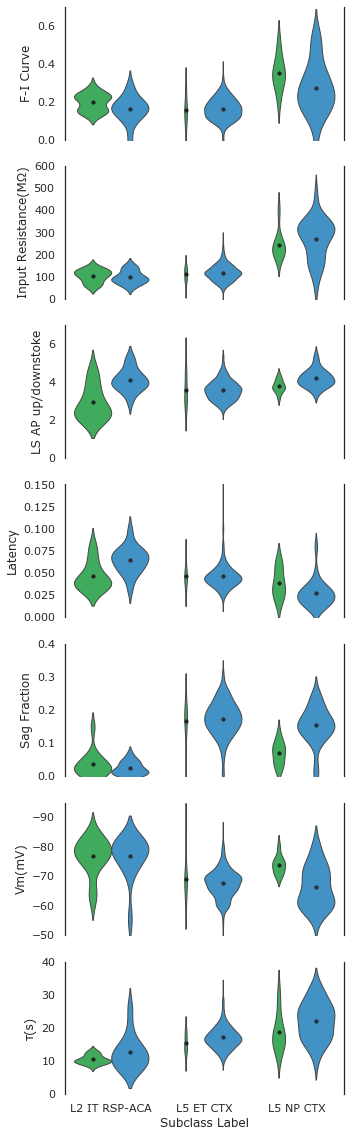

In [20]:
fig_dims = (5, 20)
f, axes = plt.subplots(nrows=7, ncols=1, figsize=fig_dims)

ax = sns.violinplot(x="subclass_label", y="F-I Curve", hue="region", data=rsp_visp_glu,
                    order=sub5_list, hue_order=region_list,
                    scale="count", inner=None, palette=s_colors, saturation=1, linewidth=1, ax=axes[0])
ax = sns.stripplot(x="subclass_label", y="F-I Curve", hue="region", data=vio_df,
                   order = sub5_list, hue_order = region_list,
                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[0])

ax1 = sns.violinplot(x="subclass_label", y="Input Resistance(MΩ)", hue="region", data=rsp_visp_glu,
                    order=sub5_list, hue_order=region_list,
                    scale="count", inner=None, palette=s_colors, saturation=1, linewidth=1, ax=axes[1])
ax1 = sns.stripplot(x="subclass_label", y="Input Resistance(MΩ)", hue="region", data=vio_df,
                   order = sub5_list, hue_order = region_list,
                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[1])

ax2 = sns.violinplot(x="subclass_label", y="LS AP up/downstoke", hue="region", data=rsp_visp_glu,
                    order=sub5_list, hue_order=region_list,
                    scale="count", inner=None, palette=s_colors, saturation=1, linewidth=1, ax=axes[2])
ax2 = sns.stripplot(x="subclass_label", y="LS AP up/downstoke", hue="region", data=vio_df,
                   order = sub5_list, hue_order = region_list,
                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[2])

ax3 = sns.violinplot(x="subclass_label", y="Latency", hue="region", data=rsp_visp_glu,
                    order=sub5_list, hue_order=region_list,
                    scale="count", inner=None, palette=s_colors, saturation=1, linewidth=1, ax=axes[3])
ax3 = sns.stripplot(x="subclass_label", y="Latency", hue="region", data=vio_df,
                   order = sub5_list, hue_order = region_list,
                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[3])

ax4 = sns.violinplot(x="subclass_label", y="Sag Fraction", hue="region", data=rsp_visp_glu,
                    order=sub5_list, hue_order=region_list,
                    scale="count", inner=None, palette=s_colors, saturation=1, linewidth=1, ax=axes[4])
ax4 = sns.stripplot(x="subclass_label", y="Sag Fraction", hue="region", data=vio_df,
                   order = sub5_list, hue_order = region_list,
                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[4])

ax5 = sns.violinplot(x="subclass_label", y="Vm(mV)", hue="region", data=rsp_visp_glu,
                    order=sub5_list, hue_order=region_list,
                    scale="count", inner=None, palette=s_colors, saturation=1, linewidth=1, ax=axes[5])
ax5 = sns.stripplot(x="subclass_label", y="Vm(mV)", hue="region", data=vio_df,
                   order = sub5_list, hue_order = region_list,
                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[5])

ax6 = sns.violinplot(x="subclass_label", y="τ(s)", hue="region", data=rsp_visp_glu,
                    order=sub5_list, hue_order=region_list,
                    scale="count", inner=None, palette=s_colors, saturation=1, linewidth=1, ax=axes[6])
ax6 = sns.stripplot(x="subclass_label", y="τ(s)", hue="region", data=vio_df,
                   order = sub5_list, hue_order = region_list,
                   jitter=False, size=3.5, color="0.2", dodge=True, linewidth=0.5, ax=axes[6])


ax.set(ylim=(0, 0.7))
ax1.set(ylim=(0, 600))
ax2.set(ylim=(0, 7))
ax3.set(ylim=(0, 0.15))
ax4.set(ylim=(0, 0.4))
ax5.set(ylim=(-95, -50))
ax6.set(ylim=(0, 40))

ax.legend_.remove()
ax1.legend_.remove()
ax2.legend_.remove()
ax3.legend_.remove()
ax4.legend_.remove()
ax5.legend_.remove()
ax6.legend_.remove()

ax.set(xticklabels=[])
ax1.set(xticklabels=[])
ax2.set(xticklabels=[])
ax3.set(xticklabels=[])
ax4.set(xticklabels=[])
ax5.set(xticklabels=[])

ax.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("")
ax4.set_xlabel("")
ax5.set_xlabel("")
ax6.set_xlabel("Subclass Label")
sns.despine(bottom=True, right=False)

ax5.invert_yaxis()

plt.savefig(plot_path + "violinplot.jpeg", bbox_inches="tight")